In [1]:
import sys
sys.path.append("/Users/octavia/Dropbox/SVE_v2/utilities")
sys.path.append("/Users/octavia/Dropbox/SVE_v2/model")

my_modules = ['plot_functions', 'load_model_output', 
            'plot_3D_functions' 'visualize_sims']
for mod in my_modules:
    if mod in sys.modules: 
        del sys.modules[mod]


from load_model_output import *

from plot_functions import *
from visualize_sims import *
from plot_3D_functions import *

In [2]:
project_dir = "/Users/octavia/Dropbox/SVE_v2/"

base_name = "test_inflow"

base_dir = os.path.join(project_dir, 'model_output' , base_name )
figure_dir = os.path.join(project_dir, 'figures', base_name)
animation_dir = os.path.join(figure_dir, "animations")
print_input_params(base_dir)

batch:
	tr : 10
sim:
	q1_m2hr : 0.5, 1.0, 2.0, 3.0
	So : 0.01, 0.1
common:
	H_i : 0.0


In [3]:
core = load_sims(base_dir)
# core = patchy_update(core)

In [4]:
animation_dir = make_animation_dir(base_dir, project_dir)

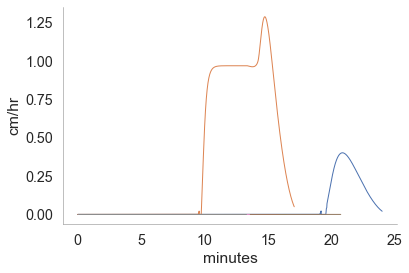

In [5]:
fig = plot_hydrographs(core[:20], nonzero=True)


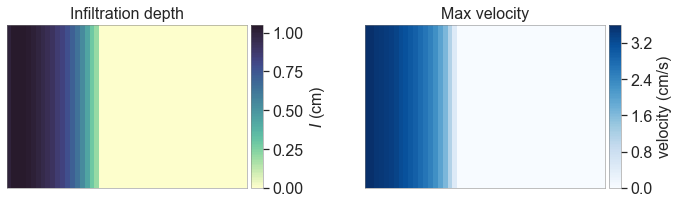

In [6]:
sim  = core.iloc[2]
fig, axes = triptych(sim)


## Prepare data 

In [7]:
import matplotlib.animation as animation
key = sim.name
N = 150 # Meshsize
fps = 5 # frame per sec

dt_anim = 10

freq = max(1, int(dt_anim/sim.dt_print))
hydro_freq =  max(1, int(dt_anim))
U = np.sqrt(sim.uc**2 + sim.vc**2)[::freq]    
hc =  sim.hc[::freq]
t_p = sim.t_print[::freq]
flux3 = sim.flux3[::hydro_freq]

h_scale = 10
frn = hc.shape[0] # frame number of the animation

yc = sim.yc
xc = sim.xc 
zc = sim.zc

def fix_axes(ax):
    """
    Set up 3D axes (and get rid of colored axis planes)
    """
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.set_xticks([], [])
    ax.set_zticks([], [])
    ax.set_yticks([], [])
    ax.grid(False)

    return ax


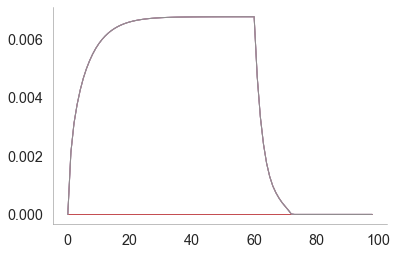

In [8]:
plt.plot(hc[:, :, -1])
plt.plot(hc[:, :, 0])

## Animate depth by velocity

MovieWriter stderr:
dyld: Library not loaded: /usr/local/opt/x264/lib/libx264.160.dylib
  Referenced from: /usr/local/bin/ffmpeg
  Reason: image not found



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '936x360', '-pix_fmt', 'rgba', '-r', '5', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/Users/octavia/Dropbox/SVE_v2_switch/figures/test_inflow/animations/tr-10,So-0.01,q1_m2hr-1.0__h_by_U.mp4']' died with <Signals.SIGABRT: 6>.

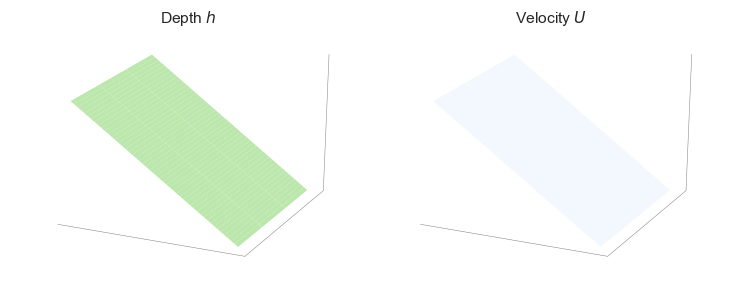

In [10]:
def update_plot(frame_number, sim, plot):  
    """
    
    """
    yc = sim.yc
    xc = sim.xc 
    zc = sim.zc
    hc = sim.hc
    
    min_z= min((zc +h_scale* hc.min(0)).ravel())
    max_z= max((zc +h_scale* hc.max(0)).ravel())
    h_norm = plt.Normalize(vmin=10*hc.ravel().min()-.01, 
                              vmax=10*hc.ravel().max())
    U_norm = plt.Normalize(vmin=10*U.ravel().min()-.01, 
                              vmax=10*U.ravel().max())  

    h_colors = cmocean.cm.deep(h_norm(hc[frame_number]*10. ))
    U_colors = cm.Blues(U_norm(U[frame_number]*10. )) 
    plot[0].remove()
    plot[0] = ax.plot_surface(xc, yc, zc + hc[frame_number]*h_scale, 
                              facecolors = h_colors,
                              linewidth=0,antialiased=True, shade=False)
    plot[1].remove()
    plot[1] = ax2.plot_surface(xc, yc, zc + hc[frame_number]*h_scale, 
                               facecolors = U_colors,
                               linewidth=0,antialiased=True, shade=False)    
    
    ax.set_zlim(min_z,max_z)
    ax2.set_zlim(min_z,max_z)
    return sim, plot


fig = plt.figure(figsize = (13, 5))
plt.subplots_adjust(wspace = 0)
plt.subplots_adjust(hspace = 0)
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax = fix_axes(ax)
ax.set_title("Depth $h$")

ax2 = fix_axes(ax2)
ax2.set_title("Velocity $U$")    

veg_norm = colors.Normalize(0., 1.1)
veg_colors = cm.Greens(veg_norm(sim.veg ))    


h_norm = colors.Normalize(vmin=10*hc.ravel().min()-.01, 
                          vmax=10*hc.ravel().max())
h_colors = cmocean.cm.deep(h_norm(hc[0]*10. ))

U_norm = colors.Normalize(vmin=10*U.ravel().min()-.01, 
                          vmax=10*U.ravel().max())  
U_colors = cm.Blues(h_norm(U[0]*10. )) 

plot =  [ax.plot_surface(xc, yc, zc + hc[0]*h_scale, facecolors = veg_colors, 
                    rstride=1, cstride=1,cmap = cmocean.cm.deep,
                    linewidth=0,antialiased=True, shade=False),
         ax2.plot_surface(xc, yc,  zc + hc[0]*h_scale, facecolors = veg_colors, 
                    rstride=1, cstride=1,
                    linewidth=0,antialiased=True, shade=False)
        ]

ax.view_init(25, 295)
ax2.view_init(25, 295)


ani = animation.FuncAnimation(fig, update_plot, frn, fargs=(sim, plot), interval=1000/fps)

file_path = os.path.join(animation_dir, key.replace('/', ',')[:-1]+'__h_by_U.mp4')
ani.save(file_path ,writer='ffmpeg',fps=fps)


## Animate depth by hydrograph

MovieWriter stderr:
dyld: Library not loaded: /usr/local/opt/libffi/lib/libffi.6.dylib
  Referenced from: /usr/local/opt/p11-kit/lib/libp11-kit.0.dylib
  Reason: image not found



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1080x360', '-pix_fmt', 'rgba', '-r', '5', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/Users/octavia/Dropbox/SVE_v2_switch/figures/test_inflow/animations/tr-10,So-0.01,q1_m2hr-1.0__h_by_hydro.mp4']' died with <Signals.SIGABRT: 6>.

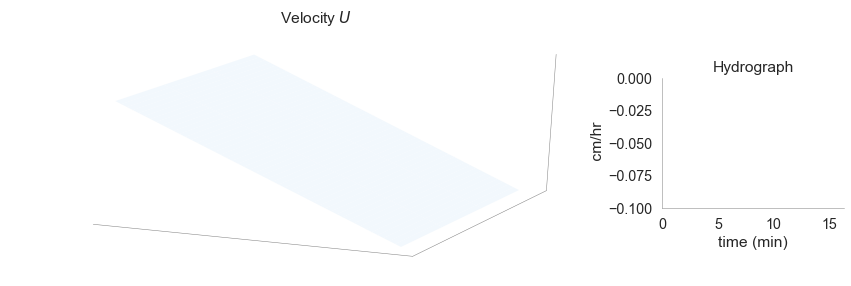

In [28]:
import matplotlib.gridspec as gridspec

def hydro_axis(ax, t_p, flux3):

    t = t_p/60.
    q = flux3*3.6e5/sim.area
    ax.set_xlim(0, t[-1])
    ax.set_ylim(-0.1, np.max(q)*1.1)
    ax.set_xlabel("time (min)")
    ax.set_ylabel(" cm/hr")
    ax.set_title("Hydrograph")

    
    return ax

def update_plot(frame_number, sim, plot):  
    yc = sim.yc
    xc = sim.xc 
    zc = sim.zc
    hc = sim.hc
    
    min_z= min((zc +h_scale* hc.min(0)).ravel())
    max_z= max((zc +h_scale* hc.max(0)).ravel())
    
    h_colors = cmocean.cm.deep(h_norm(hc[frame_number]*10. ))
    U_colors = cm.Blues(U_norm(U[frame_number]*10. )) 
    plot[0].remove()
    
    plot[0] = ax.plot_surface(xc, yc, zc + hc[frame_number]*h_scale, facecolors = U_colors,
                             linewidth=0,antialiased=True, shade=False)    

    ax.set_zlim(min_z, max_z)

    plot[1] = ax2.plot(t_p[:frame_number]/60., flux3[:frame_number]*3.6e5/sim.area, 
                       'b', animated = True)    


fig = plt.figure(figsize = (15, 5))
gs = gridspec.GridSpec(4,4)

ax = fig.add_subplot(gs[:, 0:3], projection='3d')
ax2 = fig.add_subplot(gs[1:3, 3])
ax  = fix_axes(ax)
ax2 = hydro_axis(ax2, t_p, flux3)
ax.set_title("Velocity $U$")

# Get rid of colored axes planes
h_norm = plt.Normalize(vmin=10*hc.ravel().min()-.01, vmax=10*hc.ravel().max())
U_norm = plt.Normalize(vmin=10*U.ravel().min()-.01, vmax=10*U.ravel().max())  

h_colors = cmocean.cm.deep(h_norm(hc[0]*10. ))
U_colors = cm.Blues(h_norm(U[0]*10. )) 
plot =  [ax.plot_surface(xc, yc, zc + hc[0]*h_scale , facecolors = U_colors, 
                         rstride=1, cstride=1,cmap = cmocean.cm.deep,
                        linewidth=0,antialiased=True, shade=False),
         ax2.plot([], [], animated = True),]

ani = animation.FuncAnimation(fig, update_plot, frn, fargs=(sim, plot),
                              interval=1000/fps)

ax.view_init(25, 295)

file_path = os.path.join(animation_dir, key.replace('/', ',')[:-1]+'__h_by_hydro.mp4')
ani.save(file_path ,writer='ffmpeg',fps=fps)

In [32]:
plt.rcParams['savefig.bbox'] = 'tight'

## Plot $h$ by $U$ by hydrograph

In [4]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def update_line(num, data, line):
    line.set_data(data[..., :num])
    return line,

# Fixing random state for reproducibility
np.random.seed(19680801)


# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)


fig1 = plt.figure()

data = np.random.rand(2, 25)
l, = plt.plot([], [], 'r-')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('x')
plt.title('test')
line_ani = animation.FuncAnimation(fig1, update_line, 25, fargs=(data, l),
                                   interval=50, blit=True)
line_ani.save('lines.mp4', writer=writer)

fig2 = plt.figure()

x = np.arange(-9, 10)
y = np.arange(-9, 10).reshape(-1, 1)
base = np.hypot(x, y)
ims = []
for add in np.arange(15):
    ims.append((plt.pcolor(x, y, base + add, norm=plt.Normalize(0, 30)),))

im_ani = animation.ArtistAnimation(fig2, ims, interval=50, repeat_delay=3000,
                                   blit=True)
im_ani.save('im.mp4', writer=writer)

In [5]:
def update_plot(frame_number, sim, plot):  
    """
    """
    yc = sim.yc
    xc = sim.xc 
    zc = sim.zc
    hc = sim.hc
    
    min_z= min((zc +h_scale*hc.min(0)).ravel())
    max_z= max((zc +h_scale*hc.max(0)).ravel())
    
    h_colors = cmocean.cm.deep(h_norm(hc[frame_number]*10. ))
    u_colors = cm.Blues(u_norm(U[frame_number]*10. )) 
    plot[0].remove()
    plot[0] = ax.plot_surface(xc, yc, zc + hc[frame_number]*h_scale,
                              facecolors = h_colors,
                              linewidth=0,antialiased=True, shade=False)    

    plot[1].remove()
    plot[1] = ax2.plot_surface(xc, yc, zc + hc[frame_number]*h_scale, 
                               facecolors = u_colors,
                               linewidth=0,antialiased=True, shade=False)    
    
    plot[2] = ax3.plot(t_p[:frame_number]/60., flux3[:frame_number]*3.6e5/sim.area, 
                       'b-', animated = True)
    ax.set_zlim(min_z, max_z)
    ax2.set_zlim(min_z, max_z)
    
def plot_veg_surface(ax, sim):
    """
    """
    yc = sim.yc
    xc = sim.xc 
    zc = sim.zc
    hc = sim.hc
    
    veg_norm = plt.Normalize(vmin = 0, vmax = 1.1)
    veg_colors = cm.Greens(veg_norm(sim.isvegc))    
    
    ax.plot_surface(xc, yc, zc, facecolors = veg_colors , 
                        rstride = 1, cstride = 1, alpha = 0.8,
                        linewidth=0, antialiased=True, shade=False) 
    return ax

fig = plt.figure(figsize = (16, 5))
plt.subplots_adjust(wspace = -0.1)

import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(4, 9)
ax = fig.add_subplot(gs[:, 0:3], projection='3d')
ax = fix_axes(ax)
ax2 = fig.add_subplot(gs[:, 3:6], projection='3d')
ax2 = fix_axes(ax2)
ax3 = fig.add_subplot(gs[1:3, 7:])
ax3 = hydro_axis(ax3, t_p, flux3)

ax.set_title("Depth $h$")
ax2.set_title("Velocity $U$")

# Get rid of colored axes planes 
h_norm = plt.Normalize(vmin=10*hc.ravel().min()-.01, vmax=10*hc.ravel().max())
u_norm = plt.Normalize(vmin=10*U.ravel().min()-.01, vmax=10*U.ravel().max())  

h_colors = cmocean.cm.deep(h_norm(hc[0]*10. ))
u_colors = cm.Blues(h_norm(U[0]*10. )) 
plot =  [ax.plot_surface(xc, yc,  zc + hc[0]*h_scale , facecolors = h_colors, 
                         rstride=1, cstride=1,cmap = cmocean.cm.deep,
                        linewidth=0,antialiased=True, shade=False),
          ax.plot_surface(xc, yc,  zc + hc[0]*h_scale , facecolors = u_colors, 
                         rstride=1, cstride=1,cmap = cmocean.cm.deep,
                        linewidth=0,antialiased=True, shade=False),         
          ax3.plot([], [], animated = True),]

ani = animation.FuncAnimation(fig, update_plot, frn,
                              fargs=(sim, plot), interval=1000/fps)
ax.view_init(25, 295)
ax2.view_init(25, 295)

file_path = os.path.join(animation_dir, key.replace('/', ',')[:-1]+'__h_by_U_by_hydro.mp4')
ani.save(file_path ,writer='ffmpeg',fps=fps)

ValueError: Unknown projection '3d'

# Code to compare two animations (illustrate_reveg)

In [37]:
## Match simulations by infiltration fraction
for key in core[core.fV < 1.0].index:
    sim = core.loc[key]
    err = np.abs(sim.infl_frac - core[core.fV == 1.0]['infl_frac'])
    match_key = err.loc[err == err.min()].index[0]
    match_sim = core.loc[match_key]
    core.at[key, 'match_infl_frac'] = match_sim.infl_frac
    core.loc[key, 'match_Ks'] = match_sim.Ks
    core.loc[key, 'match_key'] = match_key     


In [38]:
key = 'vegtype-randv/sigma-4,fV-0.6/'
sim = core.loc[key]
sim['U'] = np.sqrt(sim.uc**2 + sim.vc**2)

key2 = core.loc[key]['match_key']
sim2 = core.loc[key2]
sim2['U'] = np.sqrt(sim2.uc**2 + sim2.vc**2)

if sim.hc.shape[0] >  sim2.hc.shape[0]:
    pad = sim.hc.shape[0] -  sim2.hc.shape[0]
    sim2['hc']=np.pad(sim2.hc, ((0,pad), (0,0), (0, 0)), 'constant')  
elif sim2.hc.shape[0] >  sim.hc.shape[0]:
    pad = sim2.hc.shape[0] - sim.hc.shape[0]
    sim['hc']=np.pad(sim.hc, ((0,pad), (0,0), (0, 0)), 'constant')  
    
if sim.U.shape[0] >  sim2.U.shape[0]:
    pad = sim.U.shape[0] -  sim2.U.shape[0]
    sim2['U']=np.pad(sim2.U, ((0,pad), (0,0), (0, 0)), 'constant')  
elif sim2.U.shape[0] >  sim.U.shape[0]:
    pad = sim2.U.shape[0] - sim.U.shape[0]

    sim['U']=np.pad(sim.U, ((0,pad), (0,0), (0, 0)), 'constant')        

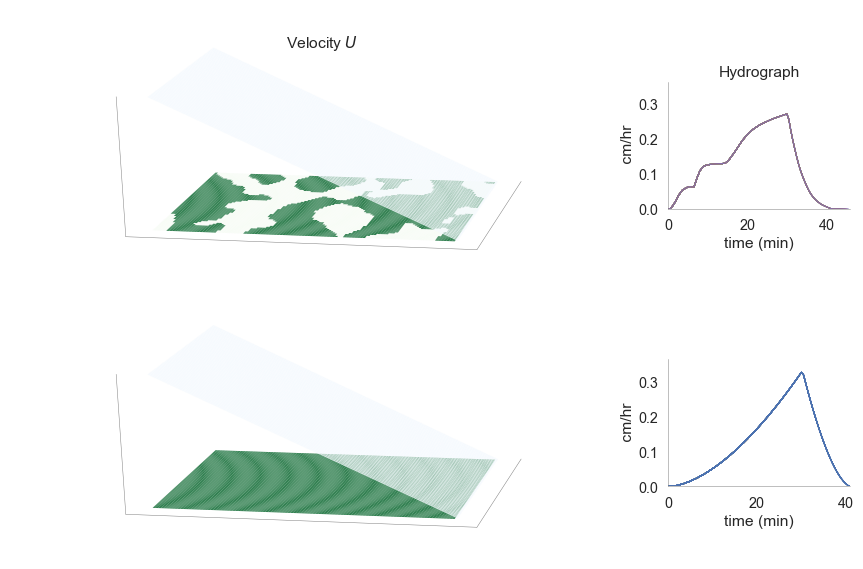

In [42]:
N = 150 # Meshsize
fps = 10 # frame per sec
frn =  min(sim.hc.shape[0], sim2.hc.shape[0]) # frame number of the animation

def diff(list1, list2):
    return list(set(list1).symmetric_difference(set(list2)))  # or return list(set(list1) ^ set(list2))

def make_axes(ax, ax2, sim):
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.set_xticks([], []);
    ax.set_zticks([], []);
    ax.set_yticks([], []);
    ax.view_init(25, 190)
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    veg_norm = plt.Normalize(vmin = 0, vmax = 1.1)

    veg_colors = cm.Greens(veg_norm(sim.isvegc))    
    
    ax.plot_surface(sim.xc, sim.yc+1 ,sim.yc*0.0 , facecolors = veg_colors , 
                        rstride = 1, cstride = 1,alpha = 0.8,
                        linewidth=0, antialiased=True, shade=False)        
    t = sim.t_p/60.
    q = sim.flux3*3600
    ax2.set_xlim(0, t[-1])
    ax2.set_xlabel("time (min)")
    ax2.set_ylabel(" cm/hr")

    ax.set_title("")    
    return ax, ax2

def update_plot(frame_number, sim, sim2, plot):  
    

    U_colors = cm.Blues(U_norm(sim.U[frame_number]*10. )) 
    U_colors2 = cm.Blues(U_norm(sim2.U[frame_number]*10. ))     
    plot[0].remove()
    plot[0] = ax.plot_surface(sim.xc, sim.yc, sim.yc/100. + sim.hc[frame_number]*10, 
                              facecolors = U_colors,
                              linewidth=0,antialiased=True, 
                              rstride = 1, cstride = 1, shade=False, alpha = 0.8)        

    plot[1] = ax2.plot(sim.t_p[:frame_number]/60., sim.flux3[:frame_number]*3600, animated = True)

    plot[2].remove()

    plot[2] = ax3.plot_surface(sim2.xc, sim2.yc, sim2.yc/100. + sim2.hc[frame_number]*10, 
                               facecolors = U_colors2,
                               linewidth=0,antialiased=True,  
                               rstride = 1, cstride = 1, shade=False, alpha = 0.8)           
    plot[3] = ax4.plot(sim2.t_p[:frame_number]/60., sim2.flux3[:frame_number]*3600,  
                               'b-', animated = True)
    

fig = plt.figure(figsize = (15, 10))

gs = gridspec.GridSpec(8,4)

ax = fig.add_subplot(gs[:4, 0:3], projection='3d')
ax2 = fig.add_subplot(gs[1:3, 3])
ax2.set_title("Hydrograph")
ax, ax2 = make_axes(ax, ax2, sim)
ax.set_title("Velocity $U$")


ax3 = fig.add_subplot(gs[4:, 0:3], projection='3d')

ax4 = fig.add_subplot(gs[5:7, 3])
ax3, ax4 = make_axes(ax3, ax4, sim2)
ax2.set_ylim(0, (max(sim2.hydro.max(), sim.hydro.max() )*3600*1.1))
ax4.set_ylim(0, (max(sim2.hydro.max(), sim.hydro.max() )*3600*1.1))                              

U_norm = colors.Normalize(vmin= -.01, vmax=10*max(sim.U.ravel().max(), 
                                                  sim2.U.ravel().max()))  

U_colors = cm.Blues(U_norm(sim.U[0]*10. )) 
U_colors2 = cm.Blues(U_norm(sim2.U[0]*10. )) 
plot =  [ax.plot_surface(sim.xc, sim.yc,  sim.yc/100. + sim.hc[0] , 
                         facecolors = U_colors, 
                         rstride=1, cstride=1,
                         linewidth=0,antialiased=True, shade=False),
          ax2.plot([], [], animated = True),
          ax3.plot_surface(sim2.xc, sim2.yc,  sim2.yc/100. + sim2.hc[0] , 
                           facecolors = U_colors2, 
                           rstride=1, cstride=1,
                           linewidth=0,antialiased=True, shade=False),
          ax4.plot([], [], animated = True),    ]
ax.set_zlim(0,1.1)
ani = animation.FuncAnimation(fig, update_plot, frn, fargs=(sim, sim2, plot), interval=1000/fps)


file_path = os.path.join(animation_dir, 
                         '_'.join( [sim['vegtype']] + diff(key.split('/') , key2.split('/') ) )+
                         '.mp4')
ani.save(file_path ,writer='ffmpeg',fps=fps)

